In [1]:
#from __future__ import division
#from __future__ import print_function

# use notebook for jupyter notebook
#%matplotlib notebook
# use inline for jupyter labs
%matplotlib inline
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
import time



Define the gas

In this example we will choose n-heptane as the gas. For a representative kinetic model, we use the 160 species mechanism by Seier et al. 2000, Proc. Comb. Inst.


In [2]:
gas = ct.Solution('/home/nijso/seiser.cti')



**** WARNING ****
For species c7h15o-1, discontinuity in h/RT detected at Tmid = 1391
	Value computed using low-temperature polynomial:  21.8343
	Value computed using high-temperature polynomial: 21.767



Define reactor conditions : temperature, pressure, fuel, stoichiometry¶


In [3]:
# Define the reactor temperature and pressure
reactorTemperature = 1000 #Kelvin
reactorPressure = 101325.0 #Pascals

gas.TP = reactorTemperature, reactorPressure

# Define the fuel, oxidizer and set the stoichiometry
gas.set_equivalence_ratio(phi=1.0, fuel='nc7h16', oxidizer={'o2':1.0, 'n2':3.76})

# Create a batch reactor object and add it to a reactor network
# In this example, the batch reactor will be the only reactor
# in the network
r = ct.IdealGasReactor(contents=gas, name='Batch Reactor')
reactorNetwork = ct.ReactorNet([r])

# now compile a list of all variables for which we will store data
stateVariableNames = [r.component_name(item) for item in range(r.n_vars)]
print(stateVariableNames)
# use the above list to create a DataFrame
#timeHistory = pd.DataFrame(columns=stateVariableNames)

['mass', 'volume', 'temperature', 'n2', 'ch3', 'h', 'ch4', 'h2', 'oh', 'h2o', 'o', 'c2h6', 'c2h5', 'hco', 'co', 'co2', 'o2', 'h2o2', 'ho2', 'c2h4', 'ch3oh', 'ch2oh', 'ch3o', 'ch2o', 'c2h2', 'c2h3', 'c2h', 'hcco', 'ch2', 'ch', 'ch2co', 'ch2(s)', 'pc2h4oh', 'ch3co', 'ch3cho', 'c3h5-s', 'c3h4-p', 'c3h5-a', 'c3h6', 'c3h4-a', 'ch3chco', 'c3h5-t', 'c4h6', 'nc3h7', 'ic3h7', 'c3h8', 'c5h9', 'c4h7', 'c4h8-1', 'sc4h9', 'pc4h9', 'ch3coch3', 'ch3coch2', 'c2h5co', 'c2h5cho', 'c5h10-1', 'ch2cho', 'c5h11-1', 'c5h11-2', 'c2h5o', 'c2h5o2', 'ch3o2', 'ch3o2h', 'c3h2', 'o2c2h4oh', 'c2h4o2h', 'c2h3co', 'c2h3cho', 'c3h5o', 'c3h6o1-2', 'c3h6ooh1-2', 'c3h6ooh2-1', 'nc3h7o', 'ic3h7o', 'nc3h7o2', 'ic3h7o2', 'c4h7o', 'c4h8ooh1-3o2', 'c4h8ooh1-3', 'nc4ket13', 'c4h8ooh1-2', 'c4h8o1-3', 'pc4h9o2', 'c3h3', 'hocho', 'c2h3o1,2', 'nc3h7cho', 'nc3h7co', 'c3h6cho-2', 'ch2ch2coch3', 'c2h5coch2', 'c2h5coc2h4p', 'nc3h7coch2', 'nc4h9cho', 'nc4h9co', 'hoch2o', 'c6h13-1', 'c6h12-1', 'c6h11', 'nc7h16', 'c7h15-1', 'c7h15-2', 'c7

In [4]:
def ignitionDelay(time, species):
    """
    This function computes the ignition delay from the occurence of the
    peak in species' concentration.
    """
    #return df[species].idxmax()
    return time[species.index(max(species))]

In [5]:
#Tic
t0 = time.time()

# This is a starting estimate. If you do not get an ignition within this time, increase it
estimatedIgnitionDelayTime = 0.1
t = 0
Y_OH=[]
Y_H2=[]
Y_T=[]
time_axis=[]
counter = 1;
while(t < estimatedIgnitionDelayTime):
    t = reactorNetwork.step()
    #print("time=",t)
    #print(counter)
    if (counter%10 == 0):
        # We will save only every 10th value. Otherwise, this takes too long
        # Note that the species concentrations are mass fractions
        #timeHistory.loc[t] = reactorNetwork.get_state()
        L = reactorNetwork.get_state()
        #print(L[8])
        time_axis.append(t)
        Y_T.append(L[2])
        Y_H2.append(L[7])
        Y_OH.append(L[8])
    counter+=1

# We will use the 'oh' species to compute the ignition delay
tau = ignitionDelay(time_axis,Y_OH)

#Toc
t1 = time.time()

print('Computed Ignition Delay: {:.3e} seconds. Took {:3.2f}s to compute'.format(tau, t1-t0))

# If you want to save all the data - molefractions, temperature, pressure, etc
# uncomment the next line
# timeHistory.to_csv("time_history.csv")

Computed Ignition Delay: 3.248e-02 seconds. Took 1.46s to compute


In [6]:
# global plot settings
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.figsize'] = [12, 8]
plt.style.use('seaborn-whitegrid')

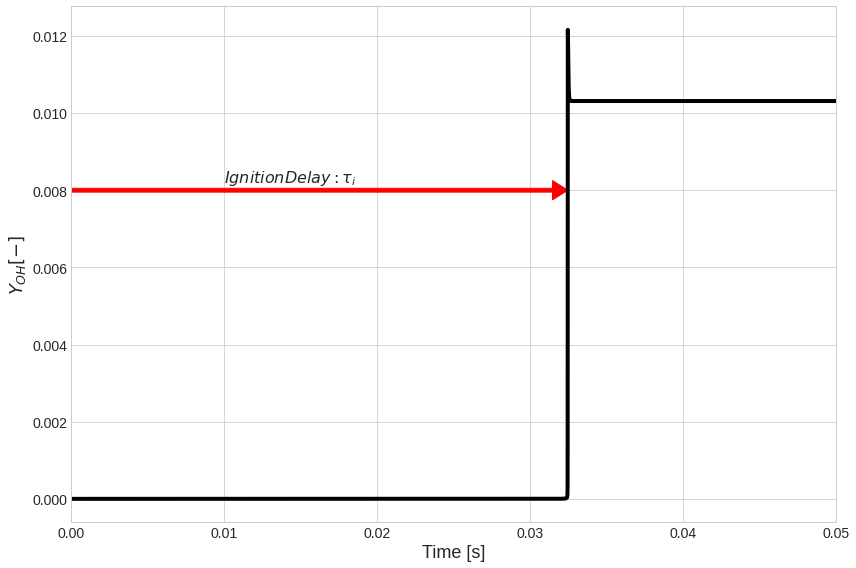

In [7]:
plt.figure()
#plt.plot(timeHistory.index, timeHistory['oh'],'-o')
plt.plot(time_axis, Y_OH,color='black',linewidth=4)
plt.xlabel('Time [s]')
plt.ylabel('$Y_{OH} [-]$')
plt.xlim([0,0.05])
plt.arrow(0, 0.008, tau, 0, width=0.0001, head_width=0.0005,head_length=0.001, length_includes_head=True, color='r', shape='full')
plt.annotate(r'$Ignition Delay: \tau_{i}$', xy=(0,0), xytext=(0.01, 0.0082), fontsize=16);


Illustration : NTC behavior

A common benchmark for a reaction mechanism is its ability to reproduce the Negative Temperature Coefficient behavior. Intuitively, as the temperature of an explosive mixture increases, it should ignite faster. But, under certain conditions, we observe the opposite. This is referred to as NTC behavior. Reproducing experimentally observed NTC behavior is thus an important test for any mechanism. We will do this now by computing and visualizing the ignition delay for a wide range of temperatures


In [8]:
# Make a list of all the temperatures we would like to run simulations at
T = [1800, 1600, 1400, 1200, 1000, 950, 925, 900, 850, 825, 800,
     750, 700, 675, 650, 625, 600, 550, 500]

estimatedIgnitionDelayTimes = np.ones(len(T))

# Make time adjustments for the highest and lowest temperatures. This we do empirically
estimatedIgnitionDelayTimes[:6] = 6*[0.1]
estimatedIgnitionDelayTimes[-2:] = 10
estimatedIgnitionDelayTimes[-1] = 100

# Now create a dataFrame out of these
#ignitionDelays = pd.DataFrame(data={'T': T})
#ignitionDelays['ignDelay'] = np.nan



Now, what we will do is simply run the code above the plots for each temperature.


In [9]:
tau=[]

for i, temperature in enumerate(T):
    # Setup the gas and reactor
    reactorTemperature = temperature
    reactorPressure = 101325.0
    gas.TP = reactorTemperature, reactorPressure
    gas.set_equivalence_ratio(phi=1.0, fuel='nc7h16', oxidizer={'o2':1.0, 'n2':3.76})
    r = ct.IdealGasReactor(contents=gas, name='Batch Reactor')
    reactorNetwork = ct.ReactorNet([r])

    # Create empty data frame
    #timeHistory = pd.DataFrame(columns=timeHistory.columns)
    Y_OH=[]
    time_axis=[]
    t0 = time.time()

    t = 0
    counter = 0
    while t < estimatedIgnitionDelayTimes[i]:
        t = reactorNetwork.step()
        if not counter % 20:
            #timeHistory.loc[t] = r.get_state()
            L = r.get_state()
            time_axis.append(t)
            Y_OH.append(L[8])
        counter += 1

    #tau = ignitionDelay(timeHistory, 'oh')
    tau_current = (ignitionDelay(time_axis,Y_OH))
    tau.append(tau_current)
    t1 = time.time()

    print('Computed Ignition Delay: {:.3e} seconds for T={}K. Took {:3.2f}s to compute'.format(tau_current, temperature, t1-t0))

    #ignitionDelays.at[i, 'ignDelay'] = tau

Computed Ignition Delay: 1.805e-05 seconds for T=1800K. Took 1.15s to compute
Computed Ignition Delay: 3.479e-05 seconds for T=1600K. Took 1.08s to compute
Computed Ignition Delay: 1.614e-04 seconds for T=1400K. Took 1.01s to compute
Computed Ignition Delay: 1.630e-03 seconds for T=1200K. Took 1.15s to compute
Computed Ignition Delay: 3.248e-02 seconds for T=1000K. Took 1.28s to compute
Computed Ignition Delay: 7.909e-02 seconds for T=950K. Took 1.35s to compute
Computed Ignition Delay: 1.252e-01 seconds for T=925K. Took 1.38s to compute
Computed Ignition Delay: 1.983e-01 seconds for T=900K. Took 1.40s to compute
Computed Ignition Delay: 4.266e-01 seconds for T=850K. Took 1.53s to compute
Computed Ignition Delay: 4.726e-01 seconds for T=825K. Took 1.48s to compute
Computed Ignition Delay: 3.795e-01 seconds for T=800K. Took 1.64s to compute
Computed Ignition Delay: 1.462e-01 seconds for T=750K. Took 1.75s to compute
Computed Ignition Delay: 6.427e-02 seconds for T=700K. Took 1.79s to co

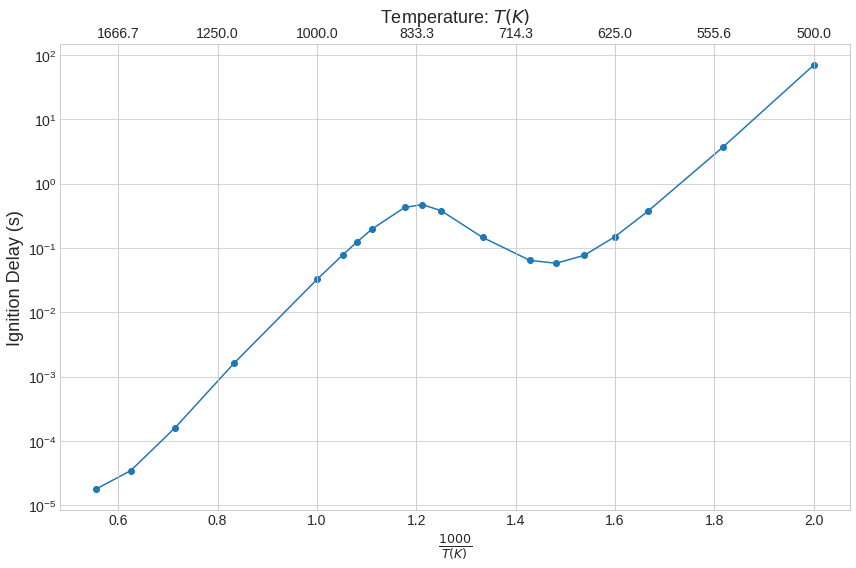

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.semilogy(1000/np.array(T), tau, 'o-')
ax.set_ylabel('Ignition Delay (s)')
ax.set_xlabel(r'$\frac{1000}{T (K)}$', fontsize=18)

# Add a second axis on top to plot the temperature for better readability
ax2 = ax.twiny()
ticks = ax.get_xticks()
ax2.set_xticks(ticks)
ax2.set_xticklabels((1000/ticks).round(1))
ax2.set_xlim(ax.get_xlim())
ax2.set_xlabel(r'Temperature: $T(K)$');